# Loading the dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping

# Load the dataset
print("Loading the dataset...")
data = pd.read_csv('melaka.csv')
print("Dataset loaded successfully.")

Loading the dataset...
Dataset loaded successfully.


# Check for missing values

In [2]:
# Check for missing values and handle them if necessary
print("Checking for missing values...")
data = data.dropna()
print("Missing values handled (if any).")


Checking for missing values...
Missing values handled (if any).


# Setting datetime as index

In [3]:
# Convert YEAR, MO, DY, HR to a datetime object and set as index
print("Converting date columns to datetime and setting as index...")
data['date'] = pd.to_datetime({'year': data['YEAR'], 'month': data['MO'], 'day': data['DY'], 'hour': data['HR']})
data.set_index('date', inplace=True)
print("Datetime conversion and indexing completed.")

Converting date columns to datetime and setting as index...
Datetime conversion and indexing completed.


# Feature engineering for cyclical time features

In [4]:
# Feature engineering for cyclical time features
print("Creating cyclical time features...")
data['hour_sin'] = np.sin(2 * np.pi * data.index.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data.index.hour / 24)
print("Cyclical time features created.")


Creating cyclical time features...
Cyclical time features created.


# Scaling the features

In [5]:
# Select features and target
print("Selecting features and target columns...")
features = ['T2M', 'WS10M', 'PRECTOTCORR', 'RH2M', 'hour_sin', 'hour_cos']
target = ['T2M', 'WS10M', 'PRECTOTCORR', 'RH2M']
print("Features and target columns selected.")

# Scale the features
print("Scaling the features...")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(data[features])
joblib.dump(scaler, 'hourly_scaler.pkl')
print("Features scaled and scaler saved.")

Selecting features and target columns...
Features and target columns selected.
Scaling the features...
Features scaled and scaler saved.


# Prepare the dataset for LSTM

In [6]:
# Prepare the dataset for LSTM
print("Preparing the dataset for LSTM...")
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 48
X, y = create_dataset(scaled_features, data[target].values, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("Dataset prepared for LSTM.")


Preparing the dataset for LSTM...
Dataset prepared for LSTM.


# Build the CNN-LSTM model


In [7]:
# Build the LSTM model
print("Building the LSTM model...")
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(len(target)))
model.compile(loss='mean_squared_error', optimizer='adam')
print("LSTM model built successfully.")

Building the LSTM model...
LSTM model built successfully.


# Train and save the model

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
print("Training the model...")
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])
print("Model training completed.")

# Save the model
print("Saving the model...")
model.save('hourly_cnn_lstm_weather_model.h5')
print("Model saved successfully.")


Training the model...
Epoch 1/100
1971/1971 [==============================] - 107s 52ms/step - loss: 433.9409 - val_loss: 54.3860
Epoch 2/100
1971/1971 [==============================] - 97s 49ms/step - loss: 57.3767 - val_loss: 48.6529
Epoch 3/100
1971/1971 [==============================] - 100s 51ms/step - loss: 56.9157 - val_loss: 39.9086
Epoch 4/100
1971/1971 [==============================] - 97s 49ms/step - loss: 15.6644 - val_loss: 3.0209
Epoch 5/100
1971/1971 [==============================] - 100s 51ms/step - loss: 12.0473 - val_loss: 3.1511
Epoch 6/100
1971/1971 [==============================] - 104s 53ms/step - loss: 11.3917 - val_loss: 1.8777
Epoch 7/100
1971/1971 [==============================] - 100s 51ms/step - loss: 10.9218 - val_loss: 2.2611
Epoch 8/100
1971/1971 [==============================] - 100s 51ms/step - loss: 10.6607 - val_loss: 1.7562
Epoch 9/100
1971/1971 [==============================] - 101s 51ms/step - loss: 10.4441 - val_loss: 1.5999
Epoch 10/100


# Plot training & validation loss values


Plotting training and validation loss...


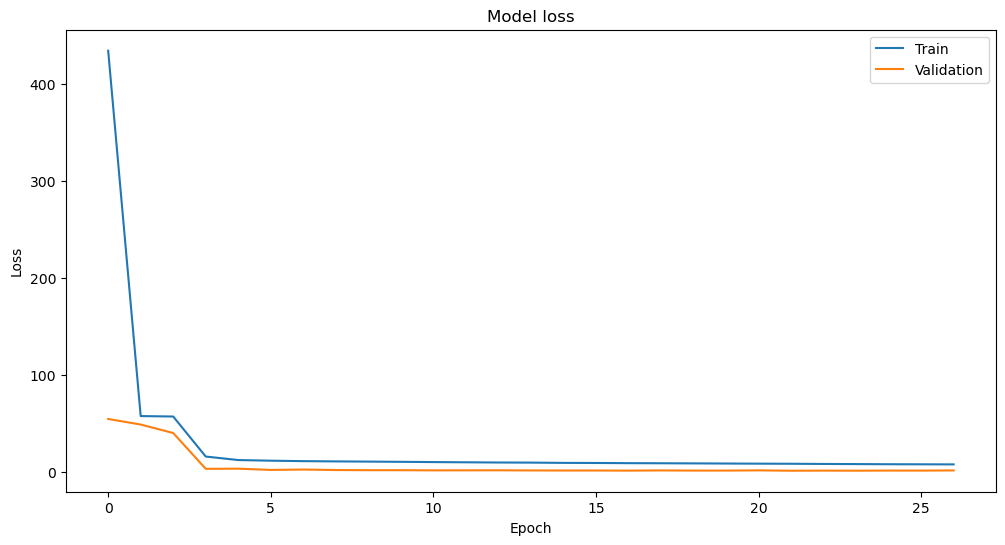

Plot displayed.


In [10]:
# Plot training & validation loss values
print("Plotting training and validation loss...")
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print("Plot displayed.")


# Evaluate the model on the test set


In [11]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

print("Calculating test loss...")
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')


Evaluating the model on the test set...
548/548 [==============================] - 10s 18ms/step
Mean Squared Error (MSE): 1.0618
Mean Absolute Error (MAE): 0.5986
Root Mean Squared Error (RMSE): 1.0304
Calculating test loss...
Test Loss: 1.0618


# Load the scaler and the model


In [12]:
# Import necessary libraries
import requests
import pandas as pd
from keras.models import load_model
import numpy as np
import joblib
import warnings
import datetime

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Load the scaler and the model
print("Loading the scaler and the model...")
scaler = joblib.load('hourly_scaler.pkl')
model = load_model('hourly_cnn_lstm_weather_model.h5')
print("Scaler and model loaded successfully.")


Loading the scaler and the model...
Scaler and model loaded successfully.


# Function to fetch the last 48 hours of data


In [13]:
# Constants
    #G82543YHG2RCV4T2NKB7DADZF
    #D8ATGRGWAUQT3RF8HQ45QXU56
    #R3TKYVPDGHETCD6YPRMCE5CYU
    #5ZH42W7ER6FFD2FZ9UQLXV3DY
    #TQQLX778KF3JTAXDDXXF7SKJC
API_KEY = "TQQLX778KF3JTAXDDXXF7SKJC"

# Function to fetch the last 48 hours of data
def fetch_weather_data():
    print("Fetching the last 48 hours of weather data...")
    
    # Get today's date and the date for the day before
    today = datetime.date.today()
    day_before = today - datetime.timedelta(days=1)

    # Format the dates as strings
    today_str = today.strftime('%Y-%m-%d')
    day_before_str = day_before.strftime('%Y-%m-%d')

    # Construct the URL
    BASE_URL = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/melaka/{day_before_str}/{today_str}"
    PARAMS = {
        'unitGroup': 'metric',
        'key': API_KEY,
        'include': 'hours'
    }

    response = requests.get(BASE_URL, params=PARAMS)
    weather_data = response.json()
    print("Weather data fetched successfully.")
    return weather_data['days']

# Fetch weather data
weather_data = fetch_weather_data()


Fetching the last 48 hours of weather data...
Weather data fetched successfully.


# Function to preprocess and predict


In [14]:
# Function to preprocess and predict
def preprocess_and_predict(weather_data):
    print("Preprocessing weather data and making predictions...")

    # Convert to DataFrame
    df = pd.DataFrame(weather_data)
    
    # Flatten the hourly data
    hourly_data = pd.DataFrame(df['hours'].tolist()).stack().reset_index(level=1, drop=True)
    hourly_df = pd.DataFrame(hourly_data.tolist())
    
    # Ensure the index is a DatetimeIndex with hourly timestamps
    hourly_df.index = pd.date_range(start=df.index[0], periods=len(hourly_df), freq='H')
    
    # Rename the columns to match the training data
    hourly_df.rename(columns={'temp': 'T2M', 'windspeed': 'WS10M', 'precip': 'PRECTOTCORR', 'humidity': 'RH2M'}, inplace=True)
    
    # Add cyclical time features
    hourly_df['hour_sin'] = np.sin(2 * np.pi * hourly_df.index.hour / 24)
    hourly_df['hour_cos'] = np.cos(2 * np.pi * hourly_df.index.hour / 24)
    
    # Select and scale features
    features = ['T2M', 'WS10M', 'PRECTOTCORR', 'RH2M', 'hour_sin', 'hour_cos']
    
    # Ensure only the last 48 rows are used for prediction
    if len(hourly_df) > 48:
        hourly_df = hourly_df.iloc[-48:]
    
    scaled_input = scaler.transform(hourly_df[features])
    scaled_input = scaled_input.reshape((1, 48, len(features)))
    
    # Make prediction for the next 48 hours
    predicted = []
    for i in range(48):
        pred = model.predict(scaled_input)
        predicted.append(pred[0])
        # Add the prediction to the input for the next prediction
        pred_with_time = np.concatenate([pred, np.array([[np.sin(2 * np.pi * (48+i) / 24), np.cos(2 * np.pi * (48+i) / 24)]])], axis=1)
        
        # Scale the new data point
        pred_with_time = scaler.transform(pred_with_time)
        
        scaled_input = np.append(scaled_input[:, 1:, :], np.expand_dims(pred_with_time, axis=0), axis=1)

    print("Predictions made successfully.")
    
    # If the targets were scaled, inverse transform them
    # Otherwise, just return the predictions
    if 'scaler_for_targets' in globals() or 'scaler_for_targets' in locals():
        predicted = scaler_for_targets.inverse_transform(predicted)
    
    return np.array(predicted), hourly_df

# Preprocess and predict
predicted, hourly_df = preprocess_and_predict(weather_data)


Preprocessing weather data and making predictions...
1/1 [==============================] - 0s 25ms/step
Predictions made successfully.


# Print the predictions neatly


In [15]:
# Print the predictions neatly
print("Printing the predictions...")

prediction_dates = pd.date_range(start=hourly_df.index[-1], periods=48, freq='H')
predicted_df = pd.DataFrame(predicted, columns=['T2M', 'WS10M', 'PRECTOTCORR', 'RH2M'], index=prediction_dates)

# Get the current datetime
current_datetime = datetime.datetime.now()

# Print the predictions with correct date and time
for i, prediction in enumerate(predicted):
    prediction_time = current_datetime + datetime.timedelta(hours=i)
    print(f"Date: {prediction_time.strftime('%Y-%m-%d %H')}")
    print(f"  Temperature (T2M): {prediction[0]:.2f} °C")
    print(f"  Wind Speed (WS10M): {prediction[1]:.2f} m/s")
    print(f"  Precipitation (PRECTOTCORR): {prediction[2]:.2f} mm")
    print(f"  Humidity (RH2M): {prediction[3]:.2f} %\n")

print("Predictions printed successfully.")


Printing the predictions...
Date: 2024-06-07 19
  Temperature (T2M): 26.27 °C
  Wind Speed (WS10M): 1.19 m/s
  Precipitation (PRECTOTCORR): 0.20 mm
  Humidity (RH2M): 80.54 %

Date: 2024-06-07 20
  Temperature (T2M): 26.40 °C
  Wind Speed (WS10M): 1.18 m/s
  Precipitation (PRECTOTCORR): 0.19 mm
  Humidity (RH2M): 77.95 %

Date: 2024-06-07 21
  Temperature (T2M): 26.41 °C
  Wind Speed (WS10M): 1.17 m/s
  Precipitation (PRECTOTCORR): 0.19 mm
  Humidity (RH2M): 77.94 %

Date: 2024-06-07 22
  Temperature (T2M): 26.27 °C
  Wind Speed (WS10M): 1.18 m/s
  Precipitation (PRECTOTCORR): 0.18 mm
  Humidity (RH2M): 78.42 %

Date: 2024-06-07 23
  Temperature (T2M): 26.37 °C
  Wind Speed (WS10M): 1.17 m/s
  Precipitation (PRECTOTCORR): 0.19 mm
  Humidity (RH2M): 79.04 %

Date: 2024-06-08 00
  Temperature (T2M): 26.32 °C
  Wind Speed (WS10M): 1.18 m/s
  Precipitation (PRECTOTCORR): 0.20 mm
  Humidity (RH2M): 80.34 %

Date: 2024-06-08 01
  Temperature (T2M): 26.27 °C
  Wind Speed (WS10M): 1.23 m/s
  P

# Plotting the predictions

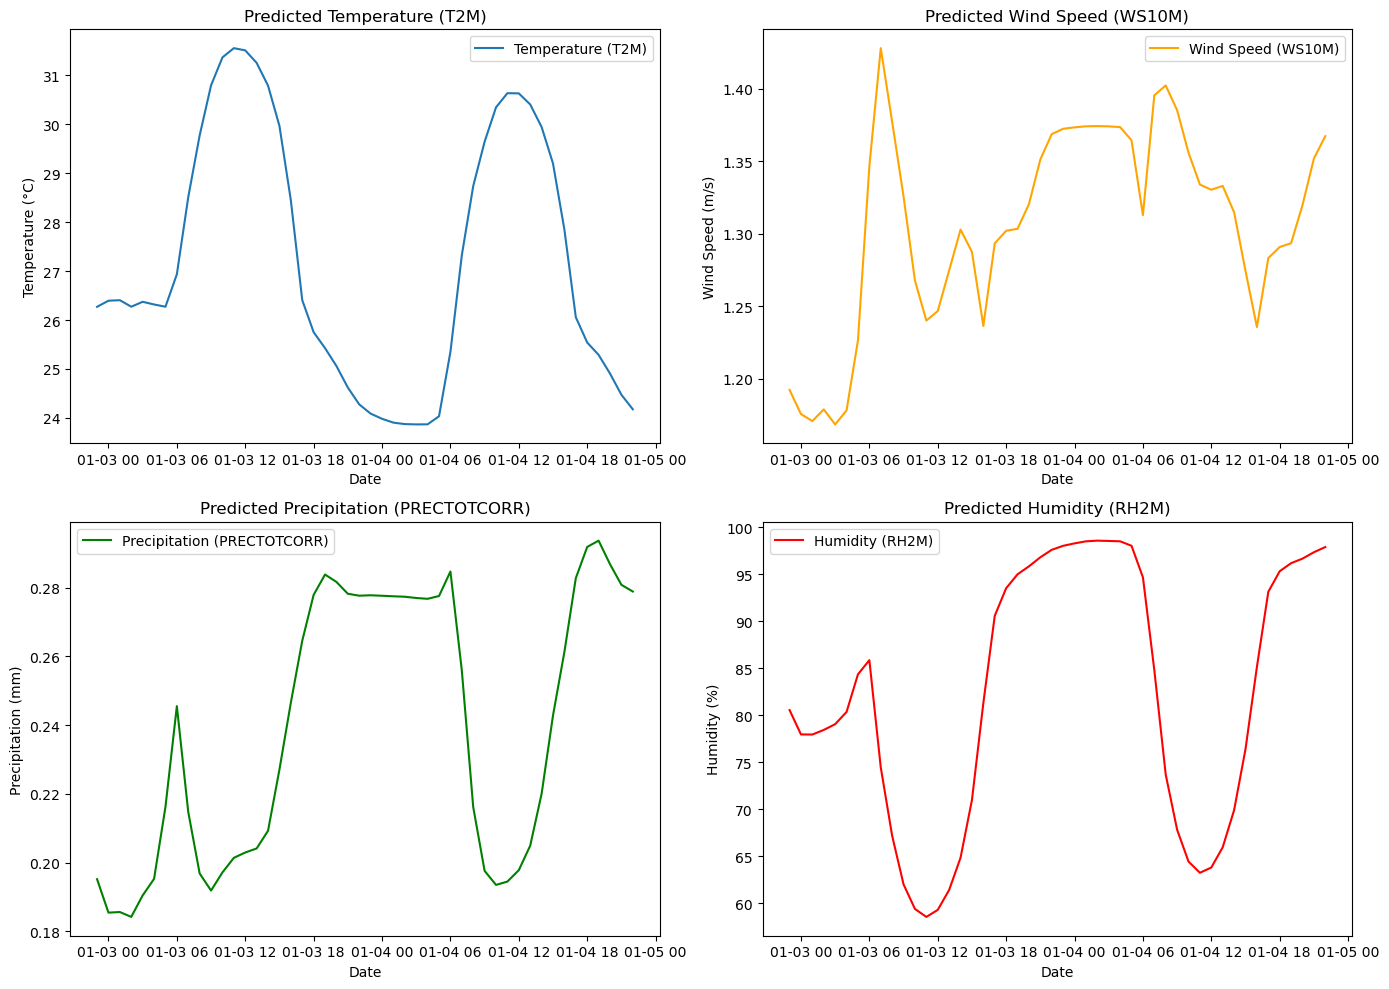

In [16]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 10))

# Temperature
plt.subplot(2, 2, 1)
plt.plot(predicted_df.index, predicted_df['T2M'], label='Temperature (T2M)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Predicted Temperature (T2M)')
plt.legend()

# Wind Speed
plt.subplot(2, 2, 2)
plt.plot(predicted_df.index, predicted_df['WS10M'], label='Wind Speed (WS10M)', color='orange')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.title('Predicted Wind Speed (WS10M)')
plt.legend()

# Precipitation
plt.subplot(2, 2, 3)
plt.plot(predicted_df.index, predicted_df['PRECTOTCORR'], label='Precipitation (PRECTOTCORR)', color='green')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.title('Predicted Precipitation (PRECTOTCORR)')
plt.legend()

# Humidity
plt.subplot(2, 2, 4)
plt.plot(predicted_df.index, predicted_df['RH2M'], label='Humidity (RH2M)', color='red')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Predicted Humidity (RH2M)')
plt.legend()

plt.tight_layout()
plt.show()

# Plotting overtime temperature


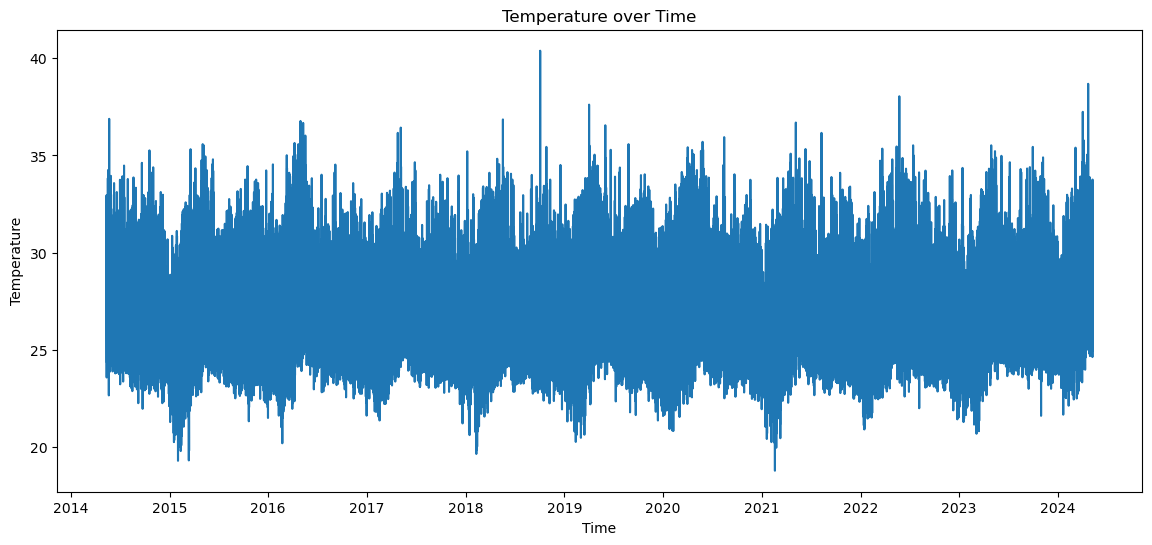

548/548 [==============================] - 9s 17ms/step


In [17]:
# Plotting the temperature
plt.figure(figsize=(14,6))
plt.plot(data.index, data['T2M'])
plt.title('Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.show()

y_pred = model.predict(X_test)

# Load the dataset and check for missing values


In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import save_model

# Load the dataset
print("Loading the dataset...")
data = pd.read_csv('melaka_daily.csv')

# Check for missing values and handle them if necessary
print("Checking for missing values...")
data = data.dropna()
print("Missing values handled.")

Loading the dataset...
Checking for missing values...
Missing values handled.


# Datetime as index and adding cyclical time features


In [29]:
# Convert YEAR, MO, DY to a datetime object and set as index
print("Converting YEAR, MO, DY to a datetime object and setting as index...")
data['date'] = pd.to_datetime({'year': data['YEAR'], 'month': data['MO'], 'day': data['DY']})
data.set_index('date', inplace=True)

# Add cyclical time features
print("Adding cyclical time features...")
data['sin_day_year'] = np.sin(2 * np.pi * data.index.dayofyear / 365)
data['cos_day_year'] = np.cos(2 * np.pi * data.index.dayofyear / 365)


Converting YEAR, MO, DY to a datetime object and setting as index...
Adding cyclical time features...


# Scaling the features


In [30]:
# Select features and target
print("Selecting features and target...")
features = ['YEAR', 'MO', 'DY', 'sin_day_year', 'cos_day_year', 'T2M_MAX', 'T2M_MIN', 'T2M', 'WS10M_MAX', 'WD10M', 'PRECTOTCORR', 'RH2M']
target = ['T2M_MAX', 'T2M_MIN', 'T2M', 'WS10M_MAX', 'WD10M', 'PRECTOTCORR', 'RH2M']

# Scale the features
print("Scaling the features...")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(data[features])
joblib.dump(scaler, 'daily_scaler.pkl')
print("Features scaled and scaler saved.")


Selecting features and target...
Scaling the features...
Features scaled and scaler saved.


# Prepare the dataset for LSTM


In [31]:
# Prepare the dataset for LSTM
print("Preparing the dataset for LSTM...")
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7  # Change this to 7 for predicting 7 days ahead
X, y = create_dataset(scaled_features, data[target].values, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print("Dataset prepared.")


Preparing the dataset for LSTM...
Dataset prepared.


# Build the CNN-LSTM model


In [32]:
# Build the CNN-LSTM model
print("Building the CNN-LSTM model...")
def create_model(filters=64, kernel_size=3, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(int(lstm_units/2), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(target)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create KerasRegressor for use in RandomizedSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define hyperparameter ranges
param_dist = {
    'filters': [16, 32, 64, 128, 256],
    'kernel_size': [3, 5, 7, 9],
    'lstm_units': [16, 32, 64, 128, 256],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}
print("CNN-LSTM model built.")


Building the CNN-LSTM model...
CNN-LSTM model built.


C:\Users\bkath\AppData\Local\Temp\ipykernel_9924\3828080314.py:16: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


# Training and saving the model

In [33]:
# Perform random search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

# Train the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = best_model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Save the model
print("Saving the model...")
save_model(best_model.model, 'daily_cnn_lstm_weather_model_best.h5')
print("Model saved.")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


D:\k3thool\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "D:\k3thool\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\k3thool\Anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 164, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "C:\Users\bkath\AppData\Local\Temp\ipykernel_9924\3828080314.py", line 6, in create_model
  File "D:\k3thool\Anaconda3\lib\site-packages\tensorf

Epoch 1/40
288/288 [==============================] - 9s 19ms/step - loss: 3558.3958 - val_loss: 2580.9539
Epoch 2/40
288/288 [==============================] - 5s 17ms/step - loss: 2075.7180 - val_loss: 1635.9060
Epoch 3/40
288/288 [==============================] - 6s 19ms/step - loss: 1403.9658 - val_loss: 1181.2958
Epoch 4/40
288/288 [==============================] - 5s 17ms/step - loss: 1091.7183 - val_loss: 977.6346
Epoch 5/40
288/288 [==============================] - 6s 22ms/step - loss: 961.0241 - val_loss: 896.4005
Epoch 6/40
288/288 [==============================] - 5s 17ms/step - loss: 909.1346 - val_loss: 867.2437
Epoch 7/40
288/288 [==============================] - 4s 15ms/step - loss: 892.4671 - val_loss: 859.2916
Epoch 8/40
288/288 [==============================] - 4s 15ms/step - loss: 890.4377 - val_loss: 857.1943
Epoch 9/40
288/288 [==============================] - 4s 14ms/step - loss: 889.6010 - val_loss: 856.6446
Epoch 10/40
288/288 [===========================

# Plot training & validation loss values


Plotting training & validation loss values...


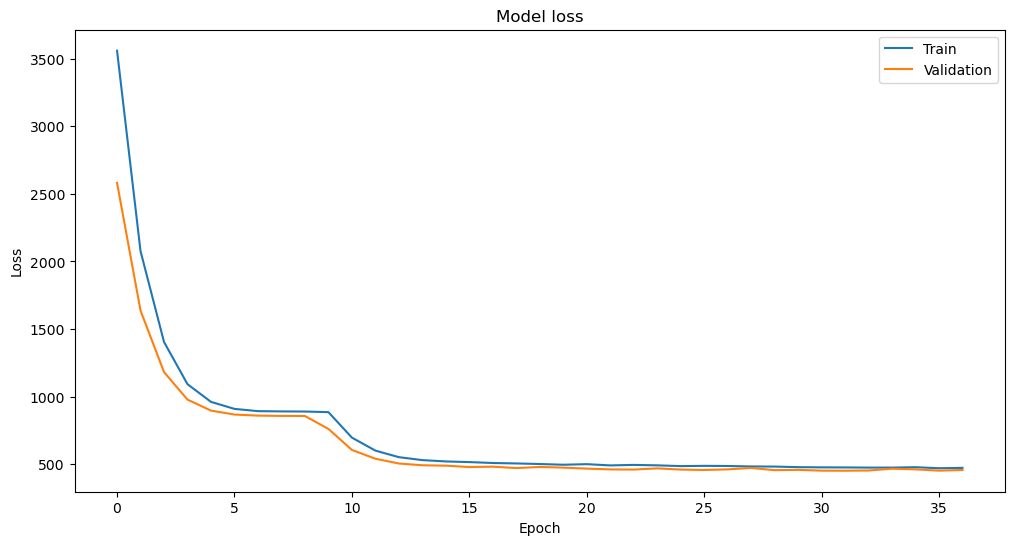

Plot displayed.


In [34]:
# Plot training & validation loss values
print("Plotting training & validation loss values...")
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
print("Plot displayed.")


# Evaluate the model on the test set


In [35]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
score = best_model.score(X_test, y_test)
print(f"Score: {score}")

# Calculate evaluation metrics
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print("Model evaluation complete.")


Evaluating the model on the test set...
Score: -473.256591796875
Mean Squared Error (MSE): 473.2566
Mean Absolute Error (MAE): 7.7400
Root Mean Squared Error (RMSE): 21.7545
Model evaluation complete.


# Load Scaler and Model


In [46]:
# Imports
import requests
import pandas as pd
from keras.models import load_model
import numpy as np
import joblib
import warnings
import datetime

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

# Load Scaler and Model
print("Loading the scaler and the model...")
scaler = joblib.load('daily_scaler.pkl')
model = load_model('daily_cnn_lstm_weather_model_best.h5')
print("Scaler and model loaded successfully.")


Loading the scaler and the model...
Scaler and model loaded successfully.


# Function to fetch the last 7 days of data


In [47]:
# Constants
    #G82543YHG2RCV4T2NKB7DADZF
    #D8ATGRGWAUQT3RF8HQ45QXU56
    #R3TKYVPDGHETCD6YPRMCE5CYU
    #5ZH42W7ER6FFD2FZ9UQLXV3DY
    #TQQLX778KF3JTAXDDXXF7SKJC
API_KEY = "TQQLX778KF3JTAXDDXXF7SKJC"

# Function to fetch the last 7 days of data
def fetch_weather_data():
    print("Fetching weather data for the last 7 days...")
    
    BASE_URL = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/melaka/last7days"
    PARAMS = {
        'unitGroup': 'metric',
        'key': API_KEY,
        'include': 'days'
    }

    response = requests.get(BASE_URL, params=PARAMS)
    weather_data = response.json()
    df = pd.DataFrame(weather_data['days'])

    # Convert date to a datetime object and set as index
    df['date'] = pd.to_datetime(df['datetime'])
    df.set_index('date', inplace=True)

    # Add 'YEAR', 'MO', 'DY', 'sin_day_year', and 'cos_day_year' features
    df['YEAR'] = df.index.year
    df['MO'] = df.index.month
    df['DY'] = df.index.day
    df['sin_day_year'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
    df['cos_day_year'] = np.cos(2 * np.pi * df.index.dayofyear / 365)

    print("Weather data fetched and processed successfully.")
    return df

# Function to preprocess and predict


In [48]:
# Function to preprocess and predict
def preprocess_and_predict(df):
    print("Preprocessing the data for prediction...")
    
    # Rename the columns to match the training data
    df.rename(columns={'tempmax': 'T2M_MAX', 'tempmin': 'T2M_MIN', 'temp': 'T2M', 'windspeed': 'WS10M_MAX', 'winddir': 'WD10M', 'precip': 'PRECTOTCORR', 'humidity': 'RH2M'}, inplace=True)
    
    # Select and scale features
    features = ['YEAR', 'MO', 'DY', 'sin_day_year', 'cos_day_year', 'T2M_MAX', 'T2M_MIN', 'T2M', 'WS10M_MAX', 'WD10M', 'PRECTOTCORR', 'RH2M']
    
    # Ensure only the last 7 rows are used for prediction
    if len(df) > 7:
        df = df.iloc[-7:]
    
    scaled_input = scaler.transform(df[features])
    scaled_input = scaled_input.reshape((1, 7, len(features)))
    
    print("Making predictions...")
    # Make prediction for the next 7 days
    predicted = []
    for i in range(7):
        pred = model.predict(scaled_input)
        predicted.append(pred[0])
        # Add the prediction to the input for the next prediction
        pred_with_time = np.concatenate([pred, np.array([[np.sin(2 * np.pi * (7+i) / 24), np.cos(2 * np.pi * (7+i) / 24)]])], axis=1)
        
        # Add 'YEAR', 'MO', 'DY'
        current_date = df.index[-1] + pd.DateOffset(days=i+1)
        pred_with_time = np.concatenate([[[current_date.year, current_date.month, current_date.day]], pred_with_time], axis=1)
        
        # Scale the new data point
        pred_with_time = scaler.transform(pred_with_time)
        
        scaled_input = np.append(scaled_input[:, 1:, :], np.expand_dims(pred_with_time, axis=0), axis=1)

    # If the targets were scaled, inverse transform them
    # Otherwise, just return the predictions
    if 'scaler_for_targets' in globals() or 'scaler_for_targets' in locals():
        predicted = scaler_for_targets.inverse_transform(predicted)
    
    print("Predictions made successfully.")
    return np.array(predicted), df

# Fetch, preprocess, and predict
df = fetch_weather_data()
predicted, df = preprocess_and_predict(df)

Fetching weather data for the last 7 days...
Weather data fetched and processed successfully.
Preprocessing the data for prediction...
Making predictions...
1/1 [==============================] - 0s 24ms/step
Predictions made successfully.


# Print the predictions neatly


In [49]:
# Print the predictions neatly
print("Formatting and printing predictions...")
prediction_dates = pd.date_range(start=df.index[-1], periods=7, freq='D')
predicted_df = pd.DataFrame(predicted, columns=['T2M_MAX', 'T2M_MIN', 'T2M', 'WS10M_MAX', 'WD10M', 'PRECTOTCORR', 'RH2M'], index=prediction_dates)

# Get the current datetime
current_datetime = datetime.datetime.now()

# Print the predictions with correct date and time
for i, prediction in enumerate(predicted):
    prediction_time = current_datetime + datetime.timedelta(days=i)
    print(f"Date: {prediction_time.strftime('%Y-%m-%d')}")
    print(f"  Maximum Temperature (T2M_MAX): {prediction[0]:.2f} °C")
    print(f"  Minimum Temperature (T2M_MIN): {prediction[1]:.2f} °C")
    print(f"  Temperature (T2M): {prediction[2]:.2f} °C")
    print(f"  Maximum Wind Speed (WS10M_MAX): {prediction[3]:.2f} m/s")
    print(f"  Wind Direction (WD10M): {prediction[4]:.2f} degrees")
    print(f"  Precipitation (PRECTOTCORR): {prediction[5]:.2f} mm")
    print(f"  Humidity (RH2M): {prediction[6]:.2f} %\n")


Formatting and printing predictions...
Date: 2024-06-07
  Maximum Temperature (T2M_MAX): 33.06 °C
  Minimum Temperature (T2M_MIN): 24.29 °C
  Temperature (T2M): 28.01 °C
  Maximum Wind Speed (WS10M_MAX): 2.13 m/s
  Wind Direction (WD10M): 78.46 degrees
  Precipitation (PRECTOTCORR): 6.63 mm
  Humidity (RH2M): 93.97 %

Date: 2024-06-08
  Maximum Temperature (T2M_MAX): 33.22 °C
  Minimum Temperature (T2M_MIN): 24.22 °C
  Temperature (T2M): 28.01 °C
  Maximum Wind Speed (WS10M_MAX): 2.30 m/s
  Wind Direction (WD10M): 64.71 degrees
  Precipitation (PRECTOTCORR): 5.73 mm
  Humidity (RH2M): 94.60 %

Date: 2024-06-09
  Maximum Temperature (T2M_MAX): 33.41 °C
  Minimum Temperature (T2M_MIN): 24.75 °C
  Temperature (T2M): 28.42 °C
  Maximum Wind Speed (WS10M_MAX): 2.00 m/s
  Wind Direction (WD10M): 126.89 degrees
  Precipitation (PRECTOTCORR): 6.04 mm
  Humidity (RH2M): 93.88 %

Date: 2024-06-10
  Maximum Temperature (T2M_MAX): 31.87 °C
  Minimum Temperature (T2M_MIN): 23.99 °C
  Temperature (T

# Plotting the predictions

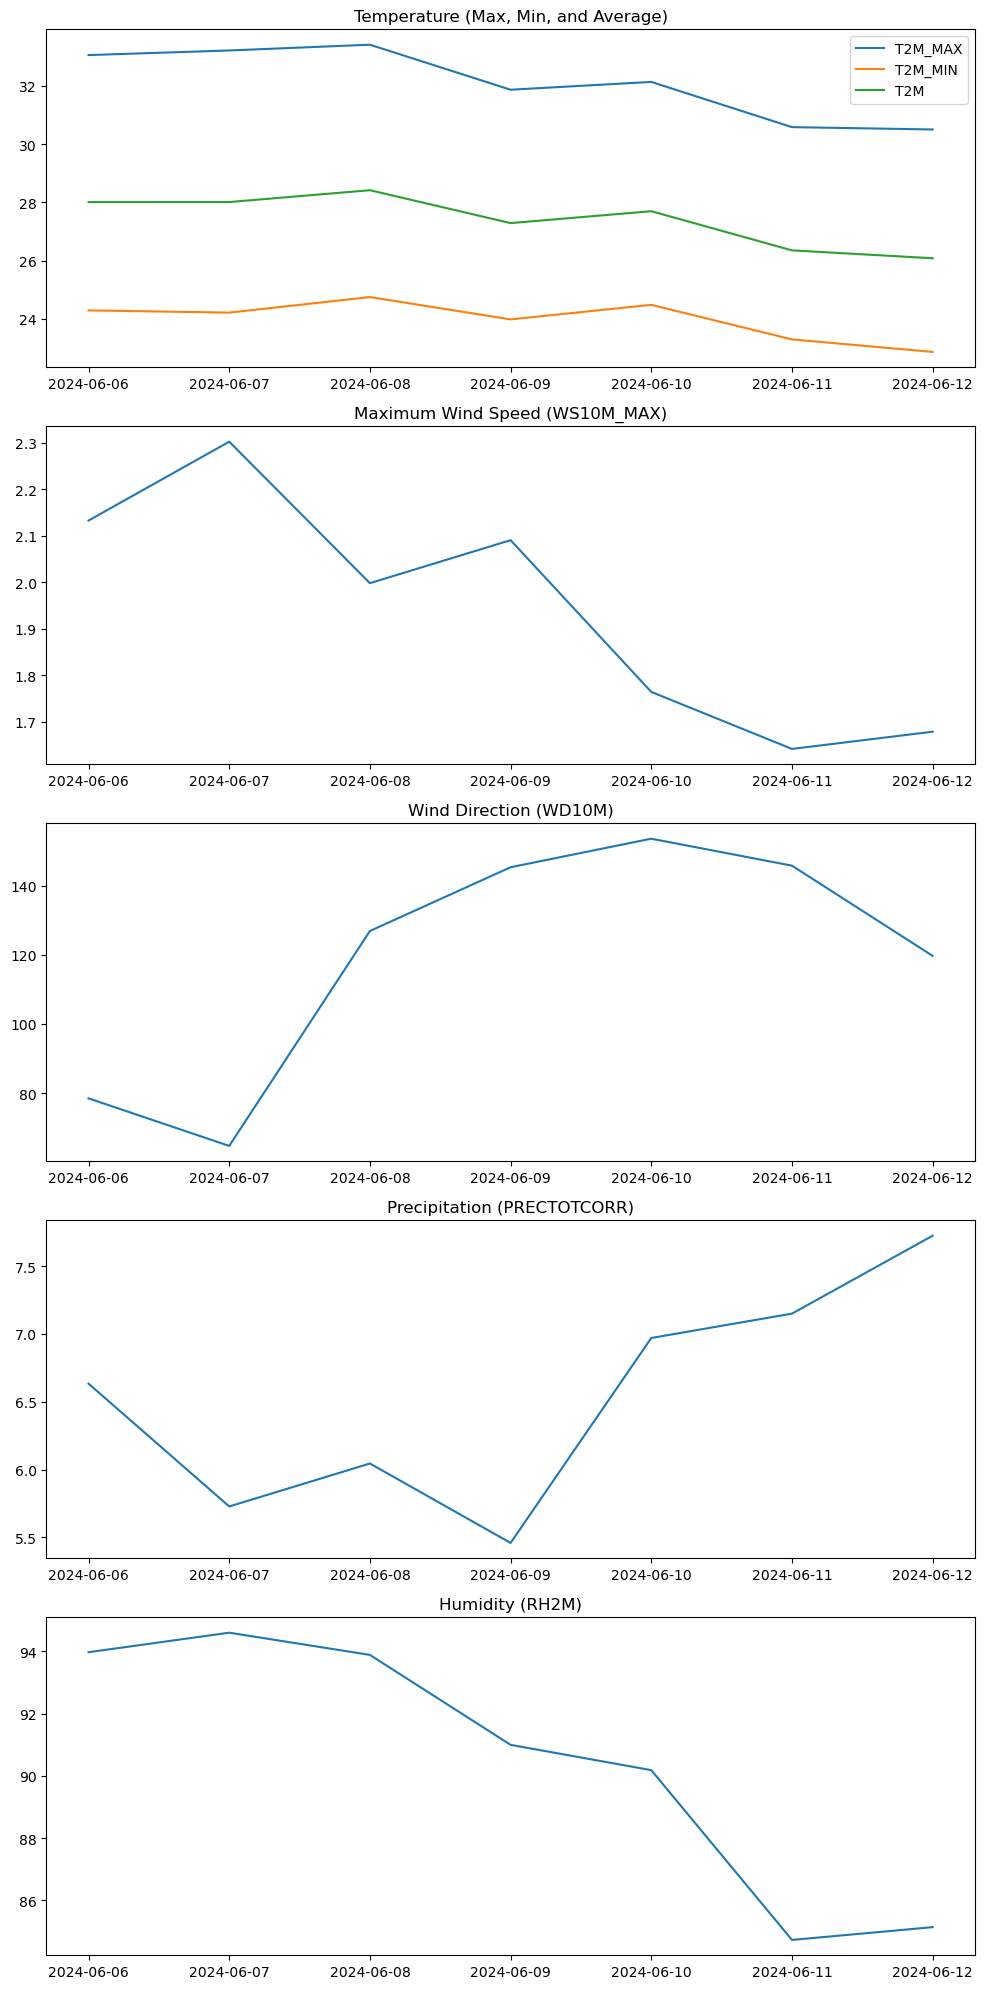

In [50]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axs = plt.subplots(5, figsize=(10, 20))

# Plot maximum, minimum, and average temperatures together
axs[0].plot(predicted_df.index, predicted_df['T2M_MAX'], label='T2M_MAX')
axs[0].plot(predicted_df.index, predicted_df['T2M_MIN'], label='T2M_MIN')
axs[0].plot(predicted_df.index, predicted_df['T2M'], label='T2M')
axs[0].set_title('Temperature (Max, Min, and Average)')
axs[0].legend()

# Plot the rest of the features
axs[1].plot(predicted_df.index, predicted_df['WS10M_MAX'])
axs[1].set_title('Maximum Wind Speed (WS10M_MAX)')

axs[2].plot(predicted_df.index, predicted_df['WD10M'])
axs[2].set_title('Wind Direction (WD10M)')

axs[3].plot(predicted_df.index, predicted_df['PRECTOTCORR'])
axs[3].set_title('Precipitation (PRECTOTCORR)')

axs[4].plot(predicted_df.index, predicted_df['RH2M'])
axs[4].set_title('Humidity (RH2M)')

# Automatically adjust subplot params so that the subplot fits into the figure area
plt.tight_layout()

# Display the figure
plt.show()
